In [444]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [445]:
#!pip install maldi-nn

In [446]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

## Parameters

In [447]:
from src.config import Config
import dill
from src.pretraining_maldi.load_data_maldi import LoadDataMaldi
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader, WeightedRandomSampler
from src.pretraining_maldi.embedder_maldi import EmbedderMaldi
from src.losscallback import LossCallback
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [448]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
results_folder='./notebooks/pretraining/results/'

In [449]:
THRESHOLD_ANALOG=0.7

In [450]:
config=Config()

In [451]:
config.epochs=1000

In [452]:
config.LR=0.001

## Loading data

In [453]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [454]:
spectrums_train=molecule_pairs_train.spectrums
spectrums_val= molecule_pairs_val.spectrums

In [455]:
dataset_train = LoadDataMaldi.from_spectra_to_dataset(spectrums_train, training=True)


Preprocessing all the data ...




0it [00:00, ?it/s]

9132it [00:00, 91316.39it/s]

18264it [00:00, 91103.02it/s]

27375it [00:00, 90506.96it/s]

36427it [00:00, 90038.44it/s]

45432it [00:00, 87615.89it/s]

54204it [00:00, 86468.41it/s]

62858it [00:00, 85492.88it/s]

71413it [00:00, 85168.62it/s]

79933it [00:00, 85165.19it/s]

88452it [00:01, 85075.31it/s]

96961it [00:01, 84796.28it/s]

105442it [00:01, 84001.66it/s]

113844it [00:01, 83745.50it/s]

122220it [00:01, 83308.02it/s]

130552it [00:01, 82012.56it/s]

138757it [00:01, 80459.52it/s]

146810it [00:01, 79156.70it/s]

154732it [00:01, 78543.40it/s]

162590it [00:01, 77885.13it/s]

170381it [00:02, 76182.61it/s]

178006it [00:02, 75197.53it/s]

185530it [00:02, 73815.65it/s]

192916it [00:02, 72292.47it/s]

200151it [00:02, 70780.46it/s]

207235it [00:02, 70319.11it/s]

214270it [00:02, 69973.39it/s]

221269it [00:02, 68402.18it/s]

228114it [00:02, 66011.06it/s]

234730it [00:03, 63930.70it/s]

241139it [00:03, 62084.49it/s]

247361it [00:03, 60172.16it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [456]:
dataset_val = LoadDataMaldi.from_spectra_to_dataset(spectrums_val)

Preprocessing all the data ...




0it [00:00, ?it/s]

8844it [00:00, 88436.29it/s]

17688it [00:00, 85961.23it/s]

32605it [00:00, 75256.21it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [457]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10
    #dataset_train, batch_size=1,  num_workers=10
)
# dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Creating train data loader


In [458]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)

Creating val data loader


In [459]:
sample = next(iter(dataset_train))

In [460]:
sample

{'mz_0': array([100.077835, 105.03234 , 105.32703 , 109.06318 , 115.05264 ,
        127.07392 , 127.13806 , 127.163506, 127.22767 , 127.31855 ,
        127.50355 , 128.06177 , 135.8138  , 141.06786 , 141.5118  ,
        151.05301 , 152.05847 , 157.06145 , 159.04128 , 167.29373 ,
        169.06158 , 173.0575  , 175.07358 , 176.03139 , 181.06256 ,
        181.28778 , 183.04295 , 185.09465 , 194.60608 , 195.07825 ,
        197.05867 , 198.06845 , 199.07408 , 200.05211 , 201.04984 ,
        206.90924 , 209.0571  , 210.95087 , 213.08696 , 215.06824 ,
        215.14525 , 215.40466 , 215.69473 , 217.08334 , 217.1416  ,
        217.19774 , 218.70152 , 219.37096 , 220.743   , 221.84476 ,
        223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
        225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
        227.19067 , 227.25436 , 227.31528 , 227.52637 , 227.74149 ,
        228.73442 , 229.04623 , 229.48248 , 230.1568  , 239.10524 ,
        240.08098 , 241.02905 , 241.0837

In [461]:
sample['mz_0']

array([100.077835, 105.03234 , 105.32703 , 109.06318 , 115.05264 ,
       127.07392 , 127.13806 , 127.163506, 127.22767 , 127.31855 ,
       127.50355 , 128.06177 , 135.8138  , 141.06786 , 141.5118  ,
       151.05301 , 152.05847 , 157.06145 , 159.04128 , 167.29373 ,
       169.06158 , 173.0575  , 175.07358 , 176.03139 , 181.06256 ,
       181.28778 , 183.04295 , 185.09465 , 194.60608 , 195.07825 ,
       197.05867 , 198.06845 , 199.07408 , 200.05211 , 201.04984 ,
       206.90924 , 209.0571  , 210.95087 , 213.08696 , 215.06824 ,
       215.14525 , 215.40466 , 215.69473 , 217.08334 , 217.1416  ,
       217.19774 , 218.70152 , 219.37096 , 220.743   , 221.84476 ,
       223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
       225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
       227.19067 , 227.25436 , 227.31528 , 227.52637 , 227.74149 ,
       228.73442 , 229.04623 , 229.48248 , 230.1568  , 239.10524 ,
       240.08098 , 241.02905 , 241.08377 , 241.55846 , 241.590

In [462]:
target_peak_index=50

In [463]:
sample['mz_0'][target_peak_index]

223.07387

In [464]:
sample['intensity_0'][target_peak_index]

0.00069894525

In [465]:
sample['sampled_mz']

array([ 51.0229  ,  59.0491  ,  60.0807  ,  65.0384  ,  68.9791  ,
        91.0501  ,  93.0444  ,  95.0485  ,  95.78077 , 100.0178  ,
       100.077835, 105.03234 , 105.033   , 105.0696  , 105.32703 ,
       107.0488  , 113.0396  , 115.05264 , 124.0417  , 127.31855 ,
       127.50355 , 130.9722  , 134.0472  , 135.8138  , 141.5118  ,
       143.0336  , 148.0474  , 149.05753 , 151.05301 , 159.04128 ,
       165.0702  , 165.0706  , 167.0701  , 169.06158 , 173.0575  ,
       175.07358 , 176.03139 , 183.04295 , 191.073   , 195.07825 ,
       197.05867 , 198.06845 , 199.07408 , 200.05211 , 210.95087 ,
       211.11    , 215.06824 , 215.14525 , 215.40466 , 215.69473 ,
       217.08334 , 217.1416  , 217.19774 , 218.70152 , 220.743   ,
       223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
       225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
       227.19067 , 227.25436 , 227.52637 , 229.48248 , 230.1568  ,
       239.10524 , 240.08098 , 241.02905 , 241.08377 , 241.558

In [466]:
sample['sampled_mz'][target_peak_index]

217.08334

In [467]:
sample['sampled_intensity'][target_peak_index]

0.019231865

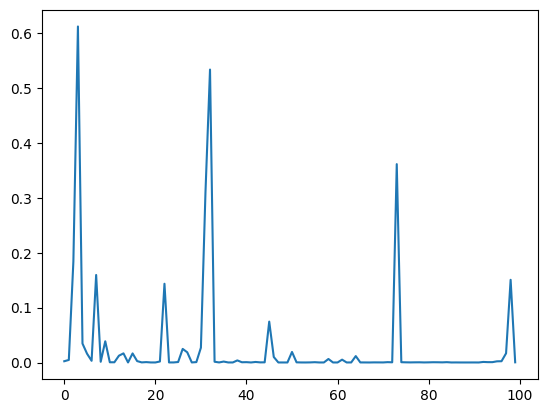

In [468]:
plt.plot(sample['sampled_intensity'], label='sampled')

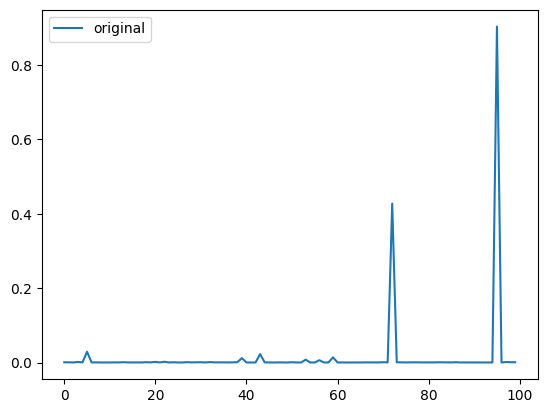

In [469]:

plt.plot(sample['intensity_0'], label = 'original')
plt.legend()

## Instantiate the training

In [470]:
# loss callback
losscallback = LossCallback(file_path=results_folder+f"loss.png")

In [471]:
config.LR

0.001

In [472]:
print("define model")

model = EmbedderMaldi(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
    )

define model


In [473]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=results_folder,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

In [474]:
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# # trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)



  | Name             | Type                             | Params
----------------------------------------------------------------------
0 | linear           | Linear                           | 16.5 K
1 | linear_output    | Linear                           | 12.9 K
2 | shared_linear    | SharedLinear                     | 129   
3 | relu             | ReLU                             | 0     
4 | spectrum_encoder | SpectrumTransformerEncoderCustom | 1.7 M 
5 | cosine_loss      | CosineEmbeddingLoss              | 0     
6 | regression_loss  | MSELoss                          | 0     
7 | dropout          | Dropout                          | 0     
----------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.846     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/Users/sebas/projects/metabolomics/src/pretraining_maldi/embedder_maldi.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch["flips"]).to(self.device)


Train loss:
[]
Validation loss
[0.6916192770004272]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.6916192770004272, 0.5708261728286743]


In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2,3,4])

In [ ]:
a[[2,3]]

In [ ]:
from the following 